## Predicting defaults in student loan applications

In [1]:
# import the desired packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import timeit
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import graphviz
import time

**1. Load the data set loandata.csv into Python.**


In [2]:
# load dataset using read_csv
loan_df = pd.read_csv('loandata.csv')
loan_df.head() # print first five rows

,field,selectiveCollege,sex,Default,loanAmount,graduationYear
0,BUSINESS,0,Male,No,59265,2012
1,STEM,0,Female,No,74496,2011
2,STEM,0,Male,No,36667,2006
3,BUSINESS,0,Male,No,40551,2007
4,BUSINESS,1,Male,No,38566,2014


**2. The data set contains some categorical predictors. Sklearn, which you should use for this exercise, can only handle numerical predictors. Translate the categorical predictors into numerical predictors.**

In [3]:
# transform the categorical attributes into numerical ones [1,0] for K-1 categories
#loan_df_dummies = pd.get_dummies(loan_df, columns=['field', 'sex', 'Default'], drop_first = True)
loan_df_dummies= pd.get_dummies(df, columns=["field","sex","Default", "graduationYear"], drop_first=True)
loan_df_dummies.head()  # print first five rows

,selectiveCollege,loanAmount,graduationYear,field_HUMANITIES,field_STEM,sex_Male,Default_Yes
0,0,59265,2012,0,0,1,0
1,0,74496,2011,0,1,0,0
2,0,36667,2006,0,1,1,0
3,0,40551,2007,0,0,1,0
4,1,38566,2014,0,0,1,0


**3. Shuffle the data set and split it into 50% training data, 25% validation data and 25% test data.**

In [4]:
# retrieve the dependent and independent variables into two different datasets
X_loan = loan_df_dummies.iloc[:,:-1] # similar as loc but use indexes
y_loan = loan_df_dummies.iloc[:,-1]

In [5]:
# split the dataframe into training set and other and add random seed so the output stays the same 
X_train, X_other, y_train, y_other = train_test_split(X_loan, y_loan, train_size=0.5, random_state=42)
# split the other set into the validation and test sets and add random seed so the output stays the same 
X_validation, X_test, y_validation, y_test = train_test_split(X_other, y_other, train_size=0.5, random_state=42)

In [6]:
# check that the split was done correctly
print("Training set is", X_train.shape[0]*100/X_loan.shape[0],"% of the total data set")  # percentage of training set
print("Validation set is",X_validation.shape[0]*100/X_loan.shape[0],"% of the total data set") # percentage of validation set
print("Test set is",X_test.shape[0]*100/X_loan.shape[0],"% of the total data set") # percentage of test set

Training set is 50.0 % of the total data set
Validation set is 25.0 % of the total data set
Test set is 25.0 % of the total data set


**4. Calculate the accuracy of the naive benchmark (majority predictor) on the validation set.**

In [7]:
naive_class = DummyClassifier(strategy = "most_frequent") # initialise naive classifier on majority predictor
naive_class.fit(X_train, y_train) # fit the model 
accuracy = naive_class.score(X_validation, y_validation) # calculate the acuracy the model 
print("The accuracy of the naive benchmark on the validation set is ", round(accuracy, 5)*100,'%')

The accuracy of the naive benchmark on the validation set is  75.446 %


**5. Train a decision tree and calculate the accuracy of this tree on the training and validation set. Choose an appropriate maximum depth and justify your choice. (Look at the max depth parameter). All other settings should be kept at default values. What do you think of this classifier?**

The best classifier is for max depth = 2 whereby the maximum accuracy on the validation data achieved is 86.931 %


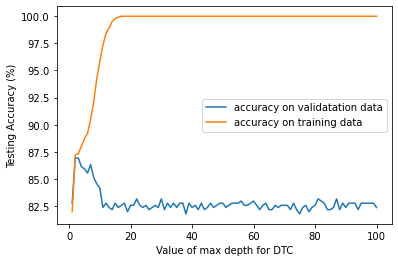

In [8]:
# we will use the DecisionTreeClassifier function available in the sklearn package
score_list_validation = [] # initialise an empty list that will iteratively be appended with the % accuracy on validation data
score_list_train = [] # initialise an empty list that will iteratively be appended with the % accuracy on training data
time_DTC = [] # keep track of training time, which will be used for comparison purposes later on
depth_range = [i for i in range(1,101)] # list containing values of max_depth from 1 to 100
for depth in depth_range: # for loop going through all the values of max depth at a time
    start = time.time() 
    DTC = DecisionTreeClassifier(max_depth = depth) # initialise a DecisionTreeClassifier for the value of max_depth
    DTC.fit(X_train, y_train.values.ravel()) # fit the model with the training data 
    end = time.time()
    y_pred_validation = DTC.predict(X_validation) # predict the validation set using the trained model
    y_pred_train = DTC.predict(X_train) # predict the training set using the trained model
    # find the number of correctly predicted data and divide by the total number of rows and append to the score lists for both
    # validation and training data
    score_list_validation.append(metrics.accuracy_score(y_validation, y_pred_validation)*100)
    score_list_train.append(metrics.accuracy_score(y_train, y_pred_train)*100)
    time_DTC.append(end-start)

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between max_depth and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1,101), score_list_validation, label = 'accuracy on validatation data')
plt.plot(range(1,101), score_list_train, label = 'accuracy on training data')
plt.xlabel('Value of max depth for DTC')
plt.ylabel('Testing Accuracy (%)')
plt.legend()
print('The best classifier is for max depth =', depth_range[score_list_validation.index(max(score_list_validation))], 
      'whereby the maximum accuracy on the validation data achieved is', round(max(score_list_validation), 3), '%')

In [9]:
print('The depth is chosen based on the maximum accuracy that can be achieved on the validation set. As can be seen from the graph, the accuracy on the validation data reaches a maximum for a depth of', 
      str(depth_range[score_list_validation.index(max(score_list_validation))])+'.', 'For larger depth values, the accuracy fluctuates around a lower accuracy level. As such, a depth of', 
                      depth_range[score_list_validation.index(max(score_list_validation))], 'is chosen.')

The depth is chosen based on the maximum accuracy that can be achieved on the validation set. As can be seen from the graph, the accuracy on the validation data reaches a maximum for a depth of 2. For larger depth values, the accuracy fluctuates around a lower accuracy level. As such, a depth of 2 is chosen.


In [10]:
# create new decision tree classifier with the max_depth that gives the best accuracy on the validation set
DTC = DecisionTreeClassifier(max_depth = depth_range[score_list_validation.index(max(score_list_validation))])
DTC.fit(X_train, y_train) # fit training data
prediction_train = DTC.predict(X_train) # predict training data to get the accuracy of this tree on the training data
prediction_validation = DTC.predict(X_validation) # predict validation data to get the accuracy of this tree on the validation data
print("The accuracy of the tree on the training data is", round(metrics.accuracy_score(y_train, prediction_train)*100,3),'%')
print("The accuracy of the tree on the validation data is", round(metrics.accuracy_score(y_validation, prediction_validation)*100,3),'%')

The accuracy of the tree on the training data is 87.228 %
The accuracy of the tree on the validation data is 86.931 %


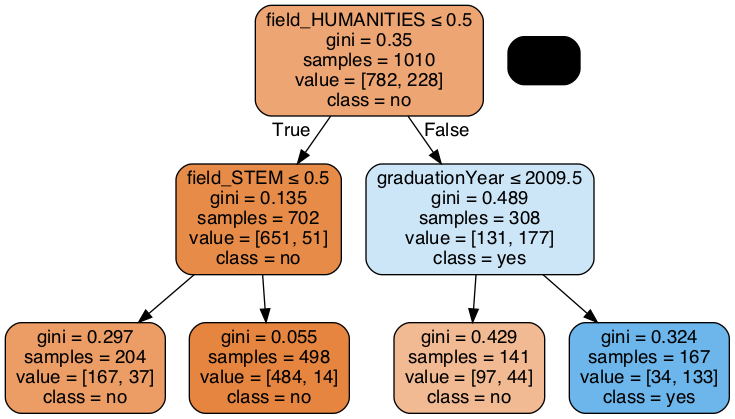

In [11]:
# visualise the decision tree using StringIO(), graphviz and pydotplus
dot_data = StringIO()
export_graphviz(DTC, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_loan.columns,class_names=['no','yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [12]:
print('This classifier achieved an accuracy of', str(round(max(score_list_validation), 3))+'%', 
      ', which is higher than the naive benchmark accuracy of', str(round(accuracy, 5)*100)+'%.',
     'As such, this classifier appears to perform well on the data.')

This classifier achieved an accuracy of 86.931% , which is higher than the naive benchmark accuracy of 75.446%. As such, this classifier appears to perform well on the data.


**6. Try a random forest algorithm instead. Use different number of estimators and plot the accuracy (on training and validation data) as a function of the number of estimators. (Look at the n estimators parameter).**

The maximum accuracy on the training data is achieved for n_estimators = 53 for an accuracy of 86.535 % whereby the accuracy on the training data is 100.0 %


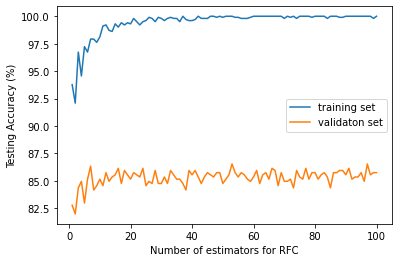

In [19]:
# we will use the RandomForestClassifier function available in the sklearn package
score_list_train_RFC = [] # initialise an empty list that will iteratively be appended the % accuracy of training set
score_list_validation_RFC = [] # initialise empty list that will iteratively be appended the % accuracy of validation set
time_list = []
estimator_range = [i for i in range(1,101)] # list containing values of max_depth from 1 to 100
for estimator in estimator_range: # for loop going through all the values of max depth at a time
    start = time.time()
    RFC = RandomForestClassifier(n_estimators = estimator) # initialise a RandomForestClassifier for n_estimators
    RFC.fit(X_train, y_train.values.ravel()) # fit the model with the training data 
    end = time.time()
    y_pred_train = RFC.predict(X_train) # predict the validation set using the trained model
    y_pred_validation = RFC.predict(X_validation) # predict the validation set using the trained model
    # find the number of correctly predicted data and divide by the total number of rows and append to cor_class_list 
    score_list_train_RFC.append(metrics.accuracy_score(y_pred_train, y_train)*100)
    score_list_validation_RFC.append(metrics.accuracy_score(y_pred_validation, y_validation)*100)
    time_list.append(end-start)
    
# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1,101), score_list_train_RFC)
plt.plot(range(1,101), score_list_validation_RFC)
plt.xlabel('Number of estimators for RFC')
plt.ylabel('Testing Accuracy (%)')
plt.legend(["training set", "validaton set"], loc ="center right")
print('The maximum accuracy on the training data is achieved for n_estimators =', 
      estimator_range[score_list_validation_RFC.index(max(score_list_validation_RFC))], 'for an accuracy of', 
      round(max(score_list_validation_RFC), 3), '%', 'whereby the accuracy on the training data is', 
      score_list_train_RFC[score_list_validation_RFC.index(max(score_list_validation_RFC))], '%')

**7. Also plot the training time (vs the number of estimators) for the random forest models in the previous step. What appropriate number of estimators would you choose? Why?**


The n_estimators corresponding to the maximum accuracy calculated in the previous part corresponds to a training time t = 0.081 ms


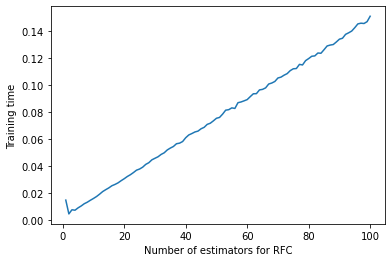

In [21]:
plt.plot(range(1,101), time_list)
plt.xlabel('Number of estimators for RFC')
plt.ylabel('Training time')
print('The n_estimators corresponding to the maximum accuracy calculated in the previous part corresponds to a training time t =', 
      round(time_list[score_list_validation_RFC.index(max(score_list_validation_RFC))],3),'ms')

In [35]:
print('Looking at the plot of accuracy vs. number of estimators, we notice that the accuracy on the validation data set initially increases quickly and then fluctuates around a value close to 85%. This tells us that the accuracy does not increase significantly for a higher number of estimators. Considering that the training time increases linearly with the number of estimators, it is best to choose the number of estimator that achieves a satisfactory level of accuracy at a low training time.',
     'Taking the tree classifier from the previous part as a benchmark, the training time was', str(round(time_DTC[score_list_validation.index(max(score_list_validation))],6))+'.',
     'As such, we would choose the number of classfiers that would result in a training time that is more or less comparable to that of the tree classifier without sacrificing accuracy too much.',
     'Based on our previous calculations, the highest accuracy was achieved at', round(max(score_list_validation_RFC), 3), '%',
     'for n_estimators =', estimator_range[score_list_validation_RFC.index(max(score_list_validation_RFC))],
     '. The training time under this number of estimators was calculated at', 
      round(time_list[score_list_validation_RFC.index(max(score_list_validation_RFC))],3),
      'ms. This might not seem like a lot of time because the training is performed on a relatively small data set - 1010 records,'
     , 'but the training time will become more significant if larger training sets were used. As such, we use our previous DTC classifier as a benchmark to compare against.',
     'In this case, the training time achieved at the maximum accuracy for the RFC model is', 
      round(time_list[score_list_validation_RFC.index(max(score_list_validation_RFC))]/time_DTC[score_list_validation.index(max(score_list_validation))],3),
     'times larger than the training time of the DTC classifier used earlier. Moreover, the DTC classifier achieved an accuracy of',
     str(round(max(score_list_validation), 3))+'%', 'which is slightly higher than the maximum accuracy achieved by the RFC model.',
     'As such, it makes more sense to choose a lower n_estimators that achieves an accuracy close to the maximum accuracy recorded, thereby sacrificing accuracy only by a small amount for a significant improvement in training time.')

print('In fact, by analyzing the plot of accuracy vs. number of estimators for the RFC model, we notice that the second peak in accuracy is achieved for a low n_estimators (< 10) and seems to produce an accuracy that is quite close to the maximum accuracy recorded.',
      'We plot the graph again, zooming in on a smaller range of n_estimators to better visualize the results')

Looking at the plot of accuracy vs. number of estimators, we notice that the accuracy on the validation data set initially increases quickly and then fluctuates around a value close to 85%. This tells us that the accuracy does not increase significantly for a higher number of estimators. Considering that the training time increases linearly with the number of estimators, it is best to choose the number of estimator that achieves a satisfactory level of accuracy at a low training time. Taking the tree classifier from the previous part as a benchmark, the training time was 0.001796. As such, we would choose the number of classfiers that would result in a training time that is more or less comparable to that of the tree classifier without sacrificing accuracy too much. Based on our previous calculations, the highest accuracy was achieved at 86.535 % for n_estimators = 53 . The training time under this number of estimators was calculated at 0.081 ms. This might not seem like a lot of time 

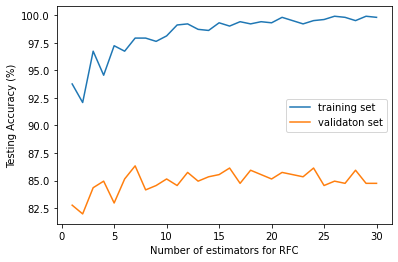

In [53]:
# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1,31), score_list_train_RFC[0:30])
plt.plot(range(1,31), score_list_validation_RFC[0:30])
plt.xlabel('Number of estimators for RFC')
plt.ylabel('Testing Accuracy (%)')
plt.legend(["training set", "validaton set"], loc ="center right")

In [57]:
print('The maximum accuracy on the validation data for the plotted range of n_estimators is achieved for n_estimators =', 
      estimator_range[score_list_validation_RFC.index(max(score_list_validation_RFC[0:30]))], 'for an accuracy of', 
      round(max(score_list_validation_RFC[0:30]), 3), '%', 'whereby the accuracy on the training data is', 
      round(score_list_train_RFC[score_list_validation_RFC.index(max(score_list_validation_RFC[0:30]))],3), '%')
print('At this n_estimators, the training time is', str(round(time_list[score_list_validation_RFC.index(max(score_list_validation_RFC[0:30]))],3))+'.',
     'This is a', round(-(time_list[score_list_validation_RFC.index(max(score_list_validation_RFC[0:30]))]-time_list[score_list_validation_RFC.index(max(score_list_validation_RFC))])/time_list[score_list_validation_RFC.index(max(score_list_validation_RFC))]*100,3), 
     '% improvement in training time with only a', -round((max(score_list_validation_RFC[0:30])-max(score_list_validation_RFC))/max(score_list_validation_RFC)*100, 3),
     '% decrease in accuracy as compared to the n_estimators that corresponds to highest accuracy across the full range of n_estimators.')
print('As such, we conclude that the best RFC classifier is chosen for n_estimators =', estimator_range[score_list_validation_RFC.index(max(score_list_validation_RFC[0:30]))])

The maximum accuracy on the training data for the plotted range of n_estimators is achieved for n_estimators = 7 for an accuracy of 86.337 % whereby the accuracy on the training data is 97.921 %
At this n_estimators, the training time is 0.012. This is a 85.137 % improvement in training time with only a 0.229 % decrease in accuracy as compared to the n_estimators that corresponds to highest accuracy across the full range of n_estimators.
As such, we conclude that the best RFC classifier is chosen for n_estimators = 7


**8. Compare and explain the performance, interpretability, training time and generalisability of your decision tree in part 5 to your chosen random forest estimator in part 7.**

Random forests is an ensemble technique which is often used to overcome the overfitting of decision trees. It essentially averages the results from multiple decision trees to decrease the overfitting. This approach has its own advantages and disadvantages depending on the aim of the model. We ran both the decision tree and random forest classifiers on the dataset and found the following key differences:

1. **Performance and generalisation:**  
If we don’t restrict the depth of a decision tree, the tree can become arbitrarily deep
and complex. Unpruned trees are therefore prone to overfitting and not generalizing
well to new data. To mitigate this issue in the DTC, we sacrificed a little performance on the training data (picked depth 2 with 86% accuracy instead of depth ~ 10 with 100%) in favor of increasing the performance on new data and achieving a validation accuracy of 87%. Because of this pre-prunning, we should expect similar results on the validation set with a decision forest since pre-prunning and deep forest are both methods to decrease overfitting.  
Indeed, the accuracy of our chosen random forest classifier on the validation data with the n_estimators=7 is 87%, which is equal to that of the decision tree classifier. However, the accuracy on the training data is much higher at 97%.  
This means that the decision tree classifier and the random forest classifier generalize equally well on new data (predictive performance). However, random forest has an edge when it comes to performance on training data, since it produces the same predictive accuracy and sacrifices less training accuracy.
  
  
2. **Interpretability:**  
In our example, the random forest classifier which balances minimising training time and maximizing accuracy has 7 estimators, meaning 7 different trees will be produced compared to just 1 in the DTC. Therefore, if the goal is to summarize the prediction making in a visually compact way to nonexperts, the DTC with a single decision tree might be a better choice. 
  
  
3. **Training time:**  
The best training time we could reach for the RFC while still achieving a validation accuracy equal to that of the DTC was 0.012 seconds, which is 7 times that of the DTC. This shows the computational complexity of the random forest approach and indicates that it may not scale well to large datasets without multi-core processing.  

**Conclusion**
In general, random forests share all of the benefits of decision trees, while making up
for some of their deficiencies. They offer equal or better training and prediction accuracy without the need for pre-prunning the maximum depth.  

However, they require a much longer time and multiprocessing on large datasets. They are also harder to interpret due to the large number of trees they usually produce. It ultimately depends on the goal.